In [25]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


$$\Large P(\textrm{hypothesis} | \textrm{data}, I) = \dfrac{P(\textrm{data} | \textrm{hypothesis}, I) P(\textrm{hypothesis} | I)}{P(\textrm{data} | I)} $$

# Section 1: Fitting a line

In astronomy, a lot of information about the physical and emission properties of astronomical objects is accessed through spectroscopic measurements, i.e., the emission intensity as a function of wavelength/frequency. Interesting spectral features are emission or absorption lines. Naturally, the lines are not... lines, but narrow peaks! A true line is impossible due to quantum effects, but in addition, local/extended effects tend to "broaden" or alter the shape of spectal lines (e.g., thermal doppler, pressure, rotation of object, 

$$\large 
y(x) = \dfrac{A}{1 + \left(\dfrac{x - x_0}{w}\right)^2}           \qquad \text{(Lorentzian or Cauchy model)}
$$

$$\large 
y(x) = A \exp{\left[-\frac{\left(x - x_0\right)^2}{2 w^2}\right]} \qquad \text{(Gaussian or Normal model)}
$$


where 
* $A$ is the amplitude (notice that $y(x_0) = A$ in both cases), 
* $x_0$ is the location paramer (the center of the line), and
* $w$ is the "spread" or width of the line.


> Notice that here we use the word Cauchy and Gaussian to refer to non-linear models rather than distributions. Our data follows the shape of the PDFs of these distributions, not the distributions themselves!


Now, let's assume we have measured the intensitities $y_i$ at given (unitless) wavelengths $x_i$, and that the errors $e_i$ are normally distributed with standard deviation $\sigma$:

$$\large y_i = y(x_i) + \epsilon_i, \qquad \epsilon_i \sim \text{Norm}(0, \sigma)$$

## The data from an unknown distribution

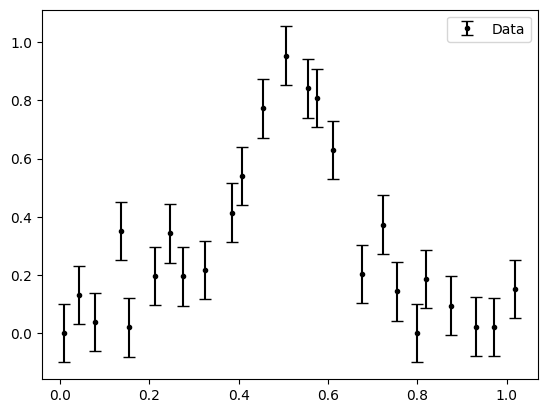

In [38]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
# np.random.seed(2024)

def make_data(x, model_dist, amplitude, location, width, error_scale=0.0):
    """Make a spectral line following the PDF of a given distribution.
    
    x           : the wavelength
    model_dist  : the distribution of which the PDF will be used
    amplitude   : the maximum height of the spectral line
    location    : the center of the spectral line
    width       : the width of the spectral line
    error_scale : the standard deviation of the observational uncertainties
    
    NOTE: use default `error_scale` (0.0) to get a model instead of observational sample.
    
    """
    distribution = model_dist(loc=location, scale=width)
    y = distribution.pdf(x)
    y = amplitude * y / np.max(y)
    if error_scale > 0:
        y = np.random.normal(y, scale=error_scale)
    y_err = np.ones_like(y) * error_scale
    return y, y_err


n_data = 25

# two potential distributions
model_distributions = [st.cauchy, st.norm]

# select pseudo-randomly the true distribution
# true_model_distribution = model_distributions[st.bernoulli(0.5).rvs()]
true_model_distribution = model_distributions[31337 % 17 % 2]

# Permitted ranges for the parameters (because we post-processed the data)
MIN_AMPLITUDE = 0.9
MAX_AMPLITUDE = 1.1
MIN_LOCATION = 0.45
MAX_LOCATION = 0.55
MIN_WIDTH = 0.05
MAX_WIDTH = 0.15

# Select the true parameters
true_amplitude = np.random.uniform(MIN_AMPLITUDE, MAX_AMPLITUDE)
true_location = np.random.uniform(MIN_LOCATION, MAX_LOCATION)
true_width = np.random.uniform(MIN_WIDTH, MAX_WIDTH)

# Make the new data according to the true model
x_data = np.linspace(0.0, 1.0, n_data) + np.random.uniform(-0.5/n_data, 0.5/n_data, size=n_data)
y_data, e_data = make_data(x_data, true_model_distribution, amplitude=true_amplitude, location=true_location, width=true_width, error_scale=0.1)
# y_data /= y_data.max()

# Plot them!
plt.figure()
plt.errorbar(x_data, y_data, yerr=e_data, fmt="k.", capsize=4, label="Data")
plt.legend(loc="upper right")
plt.show()

## Overplot two potential models using fiducial parameters

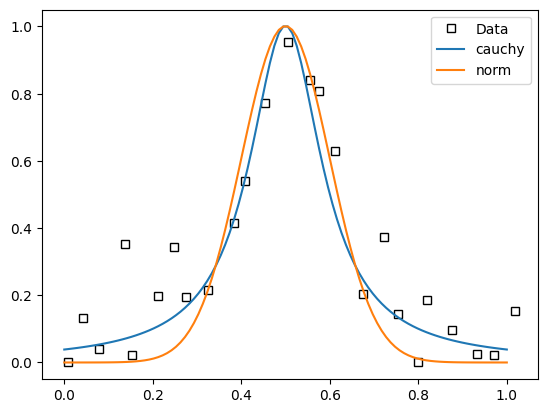

In [39]:
fiducial_amplitude = (MIN_AMPLITUDE + MAX_AMPLITUDE) / 2.0
fiducial_location = (MIN_LOCATION + MAX_LOCATION) / 2.0
fiducial_width = (MIN_WIDTH + MAX_WIDTH) / 2.0

plt.figure()
plt.plot(x_data, y_data, "ks", mfc="none", label="Data")

for model_distribution in model_distributions:
    x_plot = np.linspace(0, 1, 100)
    y_plot, _ = make_data(x_plot, 
                          model_distribution,            # try this model
                          amplitude=fiducial_amplitude,  # fiducial...
                          location=fiducial_location,    # ...parameters...
                          width=fiducial_width,          # ...from ranges
                          error_scale=0.0                # the prediction does not have uncertainty
                         )
    plt.plot(x_plot, y_plot, label=model_distribution.name)

plt.legend(loc="upper right")
plt.show()

In [40]:
def ln_prior(amplitude, location, width):
    if MIN_AMPLITUDE < amplitude < MAX_AMPLITUDE and MIN_LOCATION < location < MAX_LOCATION and MIN_WIDTH < width < MAX_WIDTH:
        return 0.0
    return -np.inf

def ln_likelihood_norm(amplitude, location, width):
    y_pred = make_data(x_data, model_dist=st.norm, amplitude=amplitude, location=location, width=width)
    chi2 = np.sum((y_data - y_pred) ** 2.0 / e_data ** 2.0)
    return -chi2 / 2.0

def ln_posterior_norm(amplitude, location, width):
    return ln_prior(amplitude, location, width) + ln_likelihood_norm(amplitude, location, width)

In [41]:
from scipy.optimize import minimize

def neg_ln_posterior_norm(theta):
    amplitude, location, width = theta
    return -ln_posterior_norm(amplitude=amplitude, location=location, width=width)

min_result_norm = minimize(neg_ln_posterior_norm, x0=[fiducial_amplitude, fiducial_location, fiducial_width], method='Nelder-Mead')
est_amplitude, est_location, est_width = min_result_norm.x


print(min_result_norm)
print()
print("| PARAMETER  |  ESTIMATION  |  TRUTH  |")
print(f"| amplitude  | {est_amplitude:11.3f}  | {true_amplitude:6.3f}  |")
print(f"| location   | {est_location:11.3f}  | {true_location:6.3f}  |")
print(f"| width      | {est_width:11.3f}  | {true_width:6.3f}  |")
print()
print("At best-fitting values...")
lnL_norm = ln_likelihood_norm(*min_result_norm.x)
lnP_norm = ln_posterior_norm(*min_result_norm.x)
print(f"  * log-prior      : {ln_prior(*min_result_norm.x):.6f}")
print(f"  * log-likelihood : {lnL_norm:.6f}")
print(f"  * log-posterior  : {lnP_norm:.6f}")

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 237.19561705443698
             x: [ 9.000e-01  5.133e-01  1.276e-01]
           nit: 63
          nfev: 119
 final_simplex: (array([[ 9.000e-01,  5.133e-01,  1.276e-01],
                       [ 9.000e-01,  5.133e-01,  1.276e-01],
                       [ 9.000e-01,  5.133e-01,  1.276e-01],
                       [ 9.000e-01,  5.133e-01,  1.276e-01]]), array([ 2.372e+02,  2.372e+02,  2.372e+02,  2.372e+02]))

| PARAMETER  |  ESTIMATION  |  TRUTH  |
| amplitude  |       0.900  |  0.944  |
| location   |       0.513  |  0.505  |
| width      |       0.128  |  0.135  |

At best-fitting values...
  * log-prior      : 0.000000
  * log-likelihood : -237.195617
  * log-posterior  : -237.195617


<font size=3><u>**In-class discussion: The fit was successful and we got parameters close to the truth. Is the Gaussian model validated?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
As in hypothesis testing, the model is assumed to be true. The fitting process does not validate the model. The value of the log-posterior does not convey any information regarding the validity of the model.
<br>
    

## Repeat using the Cauchy model

In [42]:
def ln_likelihood_cauchy(amplitude, location, width):
    y_pred = make_data(x_data, model_dist=st.cauchy, amplitude=amplitude, location=location, width=width)
    chi2 = np.sum((y_data - y_pred) ** 2.0 / e_data ** 2.0)
    return -chi2 / 2.0

def ln_posterior_cauchy(amplitude, location, width):
    return ln_prior(amplitude, location, width) + ln_likelihood_cauchy(amplitude, location, width)

def neg_ln_posterior_cauchy(theta):
    amplitude, location, width = theta
    return -ln_posterior_cauchy(amplitude=amplitude, location=location, width=width)

min_result_cauchy = minimize(neg_ln_posterior_cauchy, x0=[fiducial_amplitude, fiducial_location, fiducial_width], method='Nelder-Mead')
est_amplitude, est_location, est_width = min_result_cauchy.x

print(min_result_cauchy)
print()
print("| PARAMETER  |  ESTIMATION  |  TRUTH  |")
print(f"| amplitude  | {est_amplitude:11.3f}  | {true_amplitude:6.3f}  |")
print(f"| location   | {est_location:11.3f}  | {true_location:6.3f}  |")
print(f"| width      | {est_width:11.3f}  | {true_width:6.3f}  |")
print()
print("At best-fitting values...")
lnL_cauchy = ln_likelihood_cauchy(*min_result_cauchy.x)
lnP_cauchy = ln_posterior_cauchy(*min_result_cauchy.x)
print(f"  * log-prior      : {ln_prior(*min_result_cauchy.x):.6f}")
print(f"  * log-likelihood : {lnL_cauchy:.6f}")
print(f"  * log-posterior  : {lnP_cauchy:.6f}")

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 229.18667480105478
             x: [ 9.516e-01  5.140e-01  1.232e-01]
           nit: 46
          nfev: 87
 final_simplex: (array([[ 9.516e-01,  5.140e-01,  1.232e-01],
                       [ 9.516e-01,  5.140e-01,  1.232e-01],
                       [ 9.516e-01,  5.140e-01,  1.232e-01],
                       [ 9.515e-01,  5.140e-01,  1.232e-01]]), array([ 2.292e+02,  2.292e+02,  2.292e+02,  2.292e+02]))

| PARAMETER  |  ESTIMATION  |  TRUTH  |
| amplitude  |       0.952  |  0.944  |
| location   |       0.514  |  0.505  |
| width      |       0.123  |  0.135  |

At best-fitting values...
  * log-prior      : 0.000000
  * log-likelihood : -229.186675
  * log-posterior  : -229.186675


<font size=3><u>**In-class discussion: What can you infer from the comparison between the resulting when assuming normal vs. Cauchy?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
The parameters are in both cases close to the truth. Whether they are closer or not, in practice, we cannot use in real data because we don't know the truth!
The likelihood and posterior is, however, different! Maybe we can use this?
<br>

# Selecting models

If we don't know the correct model for the data ($D$), then we have a model selection problem. We should come up with all potential models, or at least those expected from our prior experience with the data and the underlying mechanisms decribing them.

In the case above we have the Normal and Cuachy model. Let's name them A and B respectively. We can compare the posteriors by taking their ratio:

Posterior odds: $ \dfrac{P(A|D)}{P(B|D)} $

Using the Bayes rule we can express it in the following way:

$$ \dfrac{P(A|D)}{P(B|D)} = \dfrac{P(D|A)P(A) / P(D)}{P(D|B)P(B) / P(D)} = \dfrac{P(D|A)P(A)}{P(D|B)P(B)}$$

## Dependence on the priors - Likelihood ratio

As we can see, the results depend on our prior belief on the models. In many cases, we want to be completely fair, and therefore we assign equal probability to both of them:

$$ \dfrac{P(D|A)}{P(D|B)} $$

which was used **frequentists** as well, using the **likelihood ratio statistic**:

$$ \large \mathrm{LR}_{AB} = \dfrac{L_A}{L_B} = e^{l_A - l_B} $$

where the $l_A$ and $l_B$ are the log-likelihoods for convenience.


## Connection to comparison of $\chi^2$ values

If we have Gaussian errors, then our log-likelihood is: constant $-\chi^2$.

Therefore, if we compute the $\chi^2$ values of the best fitting parameters for our models A and B, then the likelihood ratio is:

$$ \Large \mathrm{LR}_{AB} = e^{l_A - l_B} = e^{-\chi_A^2+\chi_B^2} $$

so the model with smallest $\chi_2$ is preferred.

## Taking into account the flexibility of the models

In classical statistics, we don't compare $\chi_2$ values, but the **reduced-$\chi_2$** which is divided by the degrees of freedom (number of data point - number of model parameters) to penalize complicated models that can fit the data easily without necessarily being the true model. In Bayesian statistics there are varous tools:

### AIC

If we use a model to represent the data, we lose information! There is structure/noise/etc. that we have lost! AIC measures the amount of information that is lost, **relative to another model**.

A good model "extracts" or "represents" most of the information from a system, or... it maximizes its entropy! The AIC is the application of the Second Law of Thermodynamics on statistics using information theory (cf. Shannon's information entropy).

$$\large
\text{AIC} = 2k - 2\ln L
$$

where $k$ is the number of parameters of the model (if we had to estimate them from the data), and $L$ is the likelihood of the data according to the model.

##### k is a penalty term

Using a 100-degree polynomial or a k-nearest neighbor interpolator, we could capture all trends in the data. However, this is just shifting all the information into parameters - it's not fair to compare something like that against a linear model!

### BIC

$$\large
\text{BIC} = k \ln N - 2\ln L
$$

AIC vs. BIC: it's complicated...


### BFs

Like the posterior odds or likelihood ratio, but here, the likelihoods are not that of the best fit. It takes into account all possible values for the parameters (which can be different in each model), $\theta$!

$$\large
\text{K} = \dfrac{P(D|A)}{P(D|B)} = \dfrac{\int P(\theta_A) P(D|\theta_A, A) d\theta} {\int P(\theta_B) P(D|\theta_B, B) d\theta}
$$


| Bayes Factor | Strength of evidence |
| --- | --- |
|  1 - 3.2 | Not worth more than a bare mention |
|  3.2 - 10 | Substantial |
|  10 - 100 | Strong |
|  >100 | Decisive |


### Let's compare the AICs, BICs (not the BF of the two models)

In [43]:
lnL_norm, lnL_cauchy

AIC_norm = 2 * 3 - 2 * lnL_norm
AIC_cauchy = 2 * 3 - 2 * lnL_cauchy

BIC_norm = 2 * 3 * np.log(n_data) - 2 * lnL_norm
BIC_cauchy = 2 * 3 * np.log(n_data) - 2 * lnL_cauchy

print("AIC (norm, cauchy):", AIC_norm, AIC_cauchy)
print("BIC (norm, cauchy):", BIC_norm, BIC_cauchy)
print("Posterior ratio (norm / cauchy)  =", np.exp(lnP_norm - lnP_cauchy))
print("Posterior ratio (cauchy / norm)  =", np.exp(lnP_cauchy - lnP_norm))

AIC (norm, cauchy): 480.39123410887396 464.37334960210956
BIC (norm, cauchy): 493.70448905808314 477.68660455131874
Posterior ratio (norm / cauchy)  = 0.0003324762086428609
Posterior ratio (cauchy / norm)  = 3007.7340092450922


# Exercise 1: what could you change to increase the contrast between the models?

# Exercise 2: can you compute the Bayes factor using Monte Carlo integration?